# QC Mentorship program Screening Task #2

The bit-flip code and the sign-flip code (you can find a description of both [here](https://en.wikipedia.org/wiki/Quantum_error_correction)) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

## First Section
Build the following simple circuit to prepare the Bell state: 

![Circuit](./task2-circuit.png "Circuit")

**Code:**

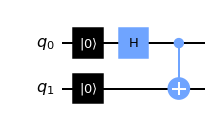

In [3]:
from qiskit import QuantumCircuit, QuantumRegister
# Create 2 qbits circuit
circuit = QuantumCircuit(2)
# By default circuit start with |0>, but we can also explicitely reset it with |0> state
circuit.reset(0)
circuit.reset(1)
# Add a H gate on qubit 0
circuit.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)
# Draw the circuit
circuit.draw('mpl')

## Second Section

Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).

## Third Section

Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that **all the possible** choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!

## Fourth Section

Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.